# ✨ **Sentiment Analysis for Book Descriptions**

In this section, we’ll enhance our Book Recommender by adding **emotional tone detection** to each book description. This gives users a new way to **filter recommendations based on emotions** like joy, sadness, excitement, etc.

---

## 🎯 **Why Sentiment Analysis?**

Because we are working with **text data**, we have the option to extract emotional signals, which traditional numeric recommenders can't provide.  
This allows **personalized filtering**:

- Looking for a **joyful** and uplifting read?
- Interested in something **suspenseful**?
- Need a **neutral** and calming book?

**Sentiment analysis** adds another layer of intelligence to our recommendations.

---

## 🧠 **What Are We Doing?**

We will **classify** each book description into **one of seven emotions**:

| Emotion        | Description |
|----------------|-------------|
| Anger          | Hostility or frustration |
| Disgust        | Repulsion or aversion |
| Fear           | Anxiety or apprehension |
| Joy            | Happiness or positivity |
| Sadness        | Sorrow or melancholy |
| Surprise       | Astonishment or shock |
| Neutral        | No strong emotional content |

Example:  
> **Description**: *"A heartwarming journey of love and friendship."*  
> **Predicted Emotion**: **Joy**

In [1]:
import torch

# For using mps (like GPU) in MACOS
print(torch.backends.mps.is_available())  # Should be True
print(torch.backends.mps.is_built())       # Should be True

True
True


In [22]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from transformers import pipeline # Use a pipeline as a high-level helper

---

## **Reading the dataset**

In [3]:
books = pd.read_csv('datasets/books_with_categories.csv')
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,short_description,title_and_subtitle,tagged_description,simple_categories
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,False,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,False,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,False,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,False,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,False,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction


---

## 🧠 **Emotion Classification Pipeline**

In this step, we use a pre-trained model for emotion classification, provided by the **Hugging Face Transformers library**. The model we use is **"emotion-english-distilroberta-base"**, fine-tuned specifically for emotion detection in English text.

In [7]:
classifier = pipeline("text-classification", 
                      model="j-hartmann/emotion-english-distilroberta-base", top_k=None, 
                      device="mps")

Device set to use mps


In [10]:
classifier('I love it')

[[{'label': 'joy', 'score': 0.9803199768066406},
  {'label': 'surprise', 'score': 0.006173066794872284},
  {'label': 'sadness', 'score': 0.004845899064093828},
  {'label': 'neutral', 'score': 0.004664232954382896},
  {'label': 'anger', 'score': 0.00252157193608582},
  {'label': 'disgust', 'score': 0.0010052365250885487},
  {'label': 'fear', 'score': 0.00047005320084281266}]]

- **`pipeline("text-classification", ...)`**:  
  This initializes a text classification pipeline. A pipeline is a high-level API in the **Hugging Face** Transformers library that makes it easier to perform common NLP tasks like text classification, sentiment analysis, and more.

- **`model="j-hartmann/emotion-english-distilroberta-base"`**:  
  We load the **DistilRoBERTa** model fine-tuned for emotion detection. The model is specifically trained on English text to classify different emotions expressed in a sentence.  
  The `j-hartmann/emotion-english-distilroberta-base` model was developed by **J. Hartmann** and fine-tuned on an emotion dataset, so it understands a variety of emotions like joy, anger, sadness, etc.

- **`return_all_scores=True`**:  
  By setting this argument to `True`, the pipeline will return all emotion scores (rather than just the predicted emotion), allowing us to examine the model's confidence across all possible emotions. This can be useful if we want to inspect or visualize how strongly the model associates the text with each emotion.


---

## 📈 **More Information on the J-Hartmann Emotion Classification Model**

The **`j-hartmann/emotion-english-distilroberta-base`** model we are using has been **fine-tuned** specifically for emotion classification tasks.  
Because it was fine-tuned on a labeled dataset, there are evaluation metrics available that give us insights into its performance.

- According to information from **[Dataloop.ai/j-hartmann-eedb](https://dataloop.ai/library/model/j-hartmann_emotion-english-distilroberta-base/)**, the model achieved an **evaluation accuracy of approximately 66%** on its validation set.
- While 66% might seem modest at first, it's important to compare this against the **random chance baseline**:
  - Since the model predicts across **7 categories** (anger, disgust, fear, joy, sadness, surprise, neutral), random guessing would yield an expected accuracy of about **14%**.
  - Thus, 66% is **significantly higher** than random, showing the model has **learned meaningful patterns** from the data.

### ✅ Why This Model is Suitable:
- It has **learned rich semantic relationships** from the training data.
- **Pre-trained** and **fine-tuned** carefully, saving us the heavy cost and time of building a custom model.
- Provides **reliable emotion predictions** to enrich our recommender system with emotional tone filtering.

Thus, we can **trust** this model and proceed to use it for measuring the emotional content in our **book descriptions**.

---

## 📖 **Deciding Sentiment Analysis Granularity**

Now that we have a working sentiment classifier capable of predicting emotions in text, the next step is **deciding how to apply it** to our book descriptions.

We have two options for applying sentiment analysis:

### 1. **Whole Description Level**

- Predict the **overall** emotion for the **entire** book description as a single block of text.
- **Pros**: Simpler, faster, less computationally expensive.
- **Cons**: Might **miss out** on nuances if the description contains **multiple emotions**.

<br>

### 2. **Sentence-by-Sentence Level**

- **Break down** each description into **individual sentences**.
- Predict the **emotion for each sentence** separately.
- **Pros**: Captures the **varied emotional tones** across different parts of the description.
- **Cons**: Slightly **more complex** and **slower**, as it processes more inputs.

<br>

### 🔍 Example Analysis

Let's take a sample book description:

> "A novel that readers and critics have been eagerly anticipating for over a decade, *Gilead* is an astonishingly imagined story of remarkable lives."

- This first sentence feels **surprising** and **joyful**.

> "Haunted by his grandfather's presence, John tells of the rift between his grandfather and his father, the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist."

- This second sentence carries feelings of **fear**, **anger**, and **sadness**.

<br>

##### If we only run sentiment analysis on the entire description, we might **lose important emotional details** embedded within different sentences.  Thus, **sentence-level sentiment analysis** could give us **richer and more accurate emotional profiles** of the books, enabling better filtering and recommendation features for users!```

In [11]:
books['description'][0]

'A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives. John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers. It’s 1956 in Gilead, Iowa, towards the end of the Reverend Ames’s life, and he is absorbed in recording his family’s story, a legacy for the young son he will never see grow up. Haunted by his grandfather’s presence, John tells of the rift between his grandfather and his father: the elder, an angry visionary who fought for the abolitionist cause, and his son, an ardent pacifist. He is troubled, too, by his prodigal namesake, Jack (John Ames) Boughton, his best friend’s lost son who returns to Gilead searching for forgiveness and redemption. Told in John Ames’s joyous, rambling voice that finds beauty, humour and truth in the smallest of life’s details, Gilead is a song of celebration and acceptance of the best and the worst the world ha

In [12]:
# Whole description level
classifier(books['description'][0])

[[{'label': 'fear', 'score': 0.6548413634300232},
  {'label': 'neutral', 'score': 0.1698521375656128},
  {'label': 'sadness', 'score': 0.11640870571136475},
  {'label': 'surprise', 'score': 0.020700665190815926},
  {'label': 'disgust', 'score': 0.01910073310136795},
  {'label': 'joy', 'score': 0.015161280520260334},
  {'label': 'anger', 'score': 0.0039351508021354675}]]

In [14]:
# Sentence by sentence level
sentences = books['description'][0].split('.')
predictions = classifier(sentences)
for sent, pred in zip(sentences, predictions):
    print(sent)
    print(pred)
    print()

A NOVEL THAT READERS and critics have been eagerly anticipating for over a decade, Gilead is an astonishingly imagined story of remarkable lives
[{'label': 'surprise', 'score': 0.7296023964881897}, {'label': 'neutral', 'score': 0.14038589596748352}, {'label': 'fear', 'score': 0.06816217303276062}, {'label': 'joy', 'score': 0.04794251546263695}, {'label': 'anger', 'score': 0.009156357496976852}, {'label': 'disgust', 'score': 0.002628477755934}, {'label': 'sadness', 'score': 0.0021221647039055824}]

 John Ames is a preacher, the son of a preacher and the grandson (both maternal and paternal) of preachers
[{'label': 'neutral', 'score': 0.4493715167045593}, {'label': 'disgust', 'score': 0.27359068393707275}, {'label': 'joy', 'score': 0.10908294469118118}, {'label': 'sadness', 'score': 0.09362741559743881}, {'label': 'anger', 'score': 0.040478210896253586}, {'label': 'surprise', 'score': 0.026970192790031433}, {'label': 'fear', 'score': 0.006879056338220835}]

 It’s 1956 in Gilead, Iowa, to

Although, sentence level sentiment analysis would be more accurate, it gives a set of emotions different for different sentences in the same description. So, how do we handle these multiple emotions for each book.

---

## 🔄 **Handling Multiple Emotions per Book Description**

When performing **sentence-level sentiment analysis**, a complication arises:  
**Multiple emotions** can now be associated with the **same book description**.

We need a **strategy** to **summarize** these multiple emotions into a usable format for our system.

---

### 🧠 **Proposed Solution**

For each book description:

- Create a **separate column** for each of the **seven emotion categories**:
  - `anger`, `disgust`, `fear`, `joy`, `sadness`, `surprise`, and `neutral`
  
- For each emotion:
  - **Take the maximum probability** score across **all sentences**.
  - This ensures that **even if only one part** of the description strongly expresses an emotion, it is **captured**.

### Example

| Sentence | Joy | Sadness | Fear | ... |
|:--------|:---:|:-------:|:----:|:---:|
| Sentence 1 | 0.12 | 0.05 | 0.02 | ... |
| Sentence 2 | 0.85 | 0.10 | 0.03 | ... |
| Sentence 3 | 0.30 | 0.50 | 0.20 | ... |

- **Joy**: `0.85` (highest across sentences)
- **Sadness**: `0.50`
- **Fear**: `0.20`
- ...

Thus, the book's final emotional profile will reflect the **strongest emotional signals** detected anywhere in its description.

In [19]:
emotion_labels = sorted(["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"])

def calculate_max_emotion_scores(predictions):
    per_emotion_scores = {label: [] for label in emotion_labels}
    for prediction in predictions:
        sorted_predictions = sorted(prediction, key=lambda x: x['label'])
        for index, label in enumerate(emotion_labels):
            per_emotion_scores[label].append(sorted_predictions[index]['score'])
    return {label: np.max(scores) for label, scores in per_emotion_scores.items()}

### **Testing for 10 descriptions**

In [ ]:
isbns = []
emotion_scores = {label: [] for label in emotion_labels}

for i in range(10):
    isbns.append(books['isbn13'][i])
    sentences = books['description'][i].split('.')
    predictions = classifier(sentences)
    max_scores = calculate_max_emotion_scores(predictions)
    for label in emotion_labels:
        emotion_scores[label].append(max_scores[label]) 

pd.DataFrame({'isbn13': isbns, **emotion_scores})   

,isbn13,anger,disgust,fear,joy,neutral,sadness,surprise
0,9780002005883,0.064134,0.273591,0.928169,0.932798,0.646216,0.967158,0.729602
1,9780002261982,0.612618,0.348285,0.942528,0.704422,0.887939,0.111690,0.252544
2,9780006178736,0.064134,0.104007,0.972321,0.767236,0.549477,0.111690,0.078765
3,9780006280897,0.351483,0.150723,0.360707,0.251881,0.732686,0.111690,0.078765
4,9780006280934,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078765
5,9780006380832,0.232225,0.727174,0.051363,0.043376,0.621393,0.111690,0.271902
6,9780006470229,0.538184,0.155855,0.747428,0.872565,0.712194,0.407999,0.078765
7,9780006472612,0.064134,0.104007,0.404496,0.040564,0.549477,0.820282,0.234488
8,9780006482079,0.300671,0.279481,0.915524,0.040564,0.840290,0.354459,0.135615
9,9780006483014,0.064134,0.177927,0.051363,0.040564,0.860372,0.111690,0.078765


It is working fine and we have seven columns one for each emotion with probabilities which are maximum across all sentences of the book description. 


**Lets work it out for all the books now.**

In [ ]:
isbns = []
emotion_scores = {label: [] for label in emotion_labels}
emotion_labels = sorted(["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"])

num_books = len(books)

for i in tqdm(range(0, num_books)):
    isbns.append(books['isbn13'][i])
    sentences = books['description'][i].split('.')
    predictions = classifier(sentences)
    max_scores = calculate_max_emotion_scores(predictions)
    for label in emotion_labels:
        emotion_scores[label].append(max_scores[label]) 

pd.DataFrame({'isbn13': isbns, **emotion_scores})   

100%|██████████| 5197/5197 [04:59<00:00, 17.37it/s]


,isbn13,anger,disgust,fear,joy,neutral,sadness,surprise
0,9780002005883,0.064134,0.273591,0.928169,0.932798,0.646216,0.967158,0.729602
1,9780002261982,0.612618,0.348285,0.942528,0.704422,0.887939,0.111690,0.252544
2,9780006178736,0.064134,0.104007,0.972321,0.767236,0.549477,0.111690,0.078765
3,9780006280897,0.351483,0.150723,0.360707,0.251881,0.732686,0.111690,0.078765
4,9780006280934,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078765
...,...,...,...,...,...,...,...,...
5192,9788172235222,0.148208,0.030643,0.919165,0.255169,0.853723,0.980877,0.030656
5193,9788173031014,0.064134,0.114383,0.051363,0.400263,0.883198,0.111690,0.227765
5194,9788179921623,0.009997,0.009929,0.339217,0.947779,0.375756,0.066685,0.057625
5195,9788185300535,0.064134,0.104007,0.459269,0.759455,0.951104,0.368110,0.078765


In [25]:
emotions_df = pd.DataFrame({'isbn13': isbns, **emotion_scores})

# Rename the columns by adding 'emotion_' prefix, except for 'isbn13'
emotions_df = emotions_df.rename(
    columns = {
        col: f"emotion_{col}" for col in emotions_df.columns if col != "isbn13"
    }
)

emotions_df


,isbn13,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_neutral,emotion_sadness,emotion_surprise
0,9780002005883,0.064134,0.273591,0.928169,0.932798,0.646216,0.967158,0.729602
1,9780002261982,0.612618,0.348285,0.942528,0.704422,0.887939,0.111690,0.252544
2,9780006178736,0.064134,0.104007,0.972321,0.767236,0.549477,0.111690,0.078765
3,9780006280897,0.351483,0.150723,0.360707,0.251881,0.732686,0.111690,0.078765
4,9780006280934,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078765
...,...,...,...,...,...,...,...,...
5192,9788172235222,0.148208,0.030643,0.919165,0.255169,0.853723,0.980877,0.030656
5193,9788173031014,0.064134,0.114383,0.051363,0.400263,0.883198,0.111690,0.227765
5194,9788179921623,0.009997,0.009929,0.339217,0.947779,0.375756,0.066685,0.057625
5195,9788185300535,0.064134,0.104007,0.459269,0.759455,0.951104,0.368110,0.078765


In [ ]:
# Merge with the original dataframe
books = pd.merge(
    books,
    emotions_df,
    on='isbn13'
)
books.head()

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,...,title_and_subtitle,tagged_description,simple_categories,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_neutral,emotion_sadness,emotion_surprise
0,9780002005883,0002005883,Gilead,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,...,Gilead,9780002005883 A NOVEL THAT READERS and critics...,Fiction,0.064134,0.273591,0.928169,0.932798,0.646216,0.967158,0.729602
1,9780002261982,0002261987,Spider's Web,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,...,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...,Fiction,0.612618,0.348285,0.942528,0.704422,0.887939,0.111690,0.252544
2,9780006178736,0006178731,Rage of angels,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,...,Rage of angels,"9780006178736 A memorable, mesmerizing heroine...",Fiction,0.064134,0.104007,0.972321,0.767236,0.549477,0.111690,0.078765
3,9780006280897,0006280897,The Four Loves,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,...,The Four Loves,9780006280897 Lewis' work on the nature of lov...,Nonfiction,0.351483,0.150723,0.360707,0.251881,0.732686,0.111690,0.078765
4,9780006280934,0006280935,The Problem of Pain,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,...,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le...",Nonfiction,0.081412,0.184495,0.095043,0.040564,0.884390,0.475881,0.078765


In [29]:
def summary(df):
    """
    Extended describe() function:
    Adds a 'missing_values' row as the third row of the describe() output.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to summarize.
    
    Returns:
    pd.DataFrame: Summary statistics including missing values.
    """
    desc = df.describe(include='all')

    # Create missing values row
    missing = df.isnull().sum()
    missing.name = 'missing'
    
    missing_perc = round(df.isnull().sum() / len(df) * 100)
    missing_perc.name = 'missing %'

    # Insert 'missing_values' as the third row
    desc = pd.concat(
        [desc.iloc[:2], 
         pd.DataFrame([missing], index=['missing']), 
         pd.DataFrame([missing_perc], index=['missing %']), 
         desc.iloc[2:]
        ],
        axis=0
    )

    # Reindex to maintain the order
    return desc

summary(books)

,isbn13,isbn10,title,authors,categories,thumbnail,description,published_year,average_rating,num_pages,...,title_and_subtitle,tagged_description,simple_categories,emotion_anger,emotion_disgust,emotion_fear,emotion_joy,emotion_neutral,emotion_sadness,emotion_surprise
count,5.197000e+03,5197,5197,5165,5167,5031,5197,5197.000000,5197.000000,5197.000000,...,5197,5197,5197,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000,5197.000000
unique,NaN,5197,4969,3045,479,5031,5154,NaN,NaN,NaN,...,5056,5197,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
missing,0.000000e+00,0,0,32,30,166,0,0.000000,0.000000,0.000000,...,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
missing %,0.000000e+00,0.0,0.0,1.0,1.0,3.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
top,NaN,0002005883,The Lord of the Rings,Agatha Christie,Fiction,http://books.google.com/books/content?id=KQZCP...,This is a reproduction of the original artefac...,NaN,NaN,NaN,...,The Lord of the Rings,9780002005883 A NOVEL THAT READERS and critics...,Fiction,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,9,30,2111,1,6,NaN,NaN,NaN,...,6,1,2808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.780667e+12,NaN,NaN,NaN,NaN,NaN,NaN,1999.804118,3.922246,348.472195,...,NaN,NaN,NaN,0.164808,0.200597,0.308601,0.280208,0.760011,0.223607,0.174044
std,5.951053e+08,NaN,NaN,NaN,NaN,NaN,NaN,9.082979,0.324975,229.891672,...,NaN,NaN,NaN,0.218574,0.212761,0.342392,0.317908,0.204866,0.248027,0.189109
min,9.780002e+12,NaN,NaN,NaN,NaN,NaN,NaN,1876.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.000606,0.000821,0.000442,0.000550,0.000981,0.001251,0.000779
25%,9.780313e+12,NaN,NaN,NaN,NaN,NaN,NaN,1998.000000,3.750000,213.000000,...,NaN,NaN,NaN,0.064134,0.104007,0.051363,0.040564,0.549477,0.111690,0.078765


---

## 📊 Boxplot of Emotion Scores

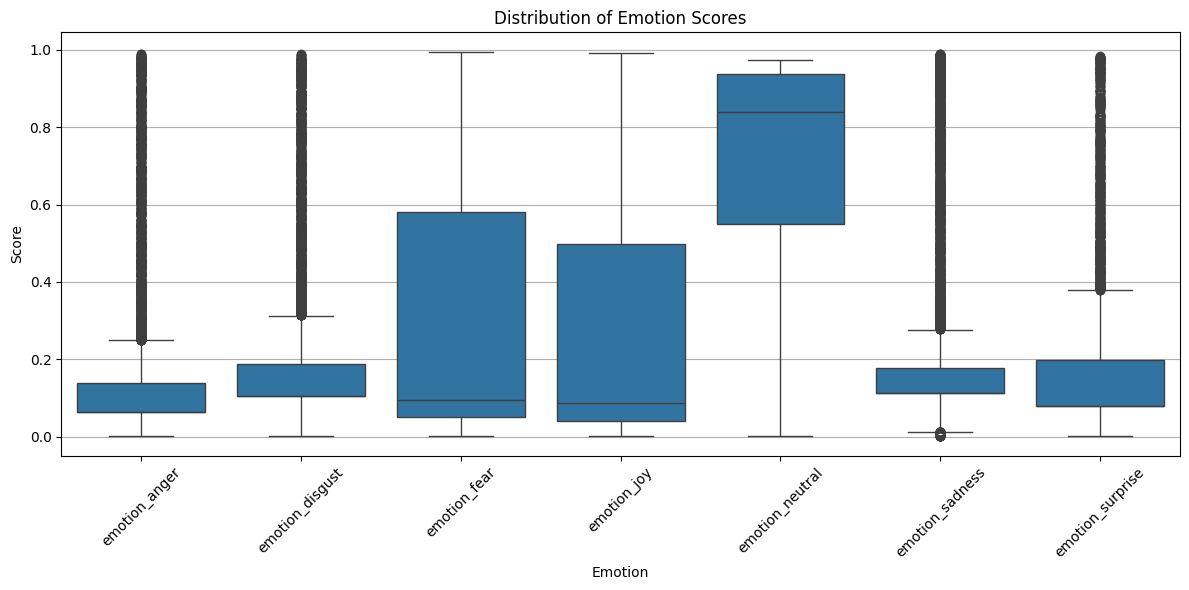

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only emotion columns (those that start with "emotion_")
emotion_cols = [col for col in emotions_df.columns if col.startswith('emotion_')]

# Melt the DataFrame to a long format
emotions_melted = emotions_df.melt(id_vars='isbn13', value_vars=emotion_cols, var_name='emotion', value_name='score')

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=emotions_melted, x='emotion', y='score')

plt.xticks(rotation=45)
plt.title('Distribution of Emotion Scores')
plt.xlabel('Emotion')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


---

### 🗂️ Creating and Saving the Final DataFrame

In [ ]:
books.to_csv('datasets/books_with_categories_and_emotions.csv', index=False)